# Distilling Diverse Counterfactual Explanations

![](images/distill-dice/introduction.jpeg "DiCE")

# The theory

Continuing my series of post, this time I'll provide an introdutory elucidation of `Counterfactual Explanations`, an interest concept that goes in the same direction of model explanation, but it is different than feature attribution methods like [@LIMEPaper] and [@SHAPPaper].

Simply speaking, according to authors from [@dice], suppose that someone who tried to get a loan but got turned down by the bank's computer system. Normally, the bank might tell them why, like "you have a bad credit history". But this doesn't give the person a clue about what they should do differently next time to get approved. Also, what the system flagged as most important might not even be something they can change, e.g. their `gender` or `race`. So, it's super crucial not only to know why you got rejected, but **also to see what changes could lead to a different result**. This way, people can figure out what actions they could've taken to swing the decision in their favor.

This leads us to the definition of Counterfactual Explanations [@CounterFactualWatcher]. Using the loan example, these would show how the same person could have changed a few things to get approved for the loan. For instance, they might say "if you earned $10,000 more, you'd have gotten the loan." Basically, these are "what-if" scenarios based on the model's results. A big plus of these counterfactual explanations is that they're always true to the original model since they're just a different take on the system's results. Plus, they can be easy for people to understand.



## The caveat

Coming up with "what-if" scenarios that someone can actually do is tough. Let's go back to the loan example. A counterfactual explanation might suggest "lower your rent", but it doesn't give other options or consider how hard different changes might be to pull off. That's why we need a variety of counterfactual examples to help people wrap their heads around these complex machine learning models. Ideally, these examples should offer a range of suggestions and think about how doable those changes are. 

:::{.callout-important}

Rules should make sense with real-world rules, like, you can't just downgrade your degree or change your race.

:::

### But what is wrong with Feature Importance methods?

Models like those mentioned in the [@LIMEPaper] and [@SHAPPaper] papers are seen as "Feature Importance" methods. They explain things by ranking the most relevant features. But here's the thing, these explanations aren't totally honest about what's going on with the machine learning models. As there is always this balancing act between being true to the model and making it understandable to humans when you're explaining a complex model, an explanation methods that use simpler stand-in models are always approximatios the real model to some extent. Therefore, one big issue with this is that because the explanations come from these simpler models, there's no guarantee that they're actually representing the original model accurately.

## Approaching the solution

Extending the work from [@CounterFactualWatcher], [@dice] authors set up an optimization problem that looks at both the diversity of the "what-if" scenarios and how close they are to the original data, coming up with a method that generates a bunch of "what-if" scenarios. Also, they provide a set of interesting metrics for evaluating counterfactual explanations, which I believe is worthwhile to explore :)

## Going Formal

So, what we're working with here is a trained machine learning model, $f$, and a specific case, $x$. Our aim is to generate a group of $k$ counterfactuals, {$c_1, c_2, \cdots{. . .}, c_k$}, that would lead to a different outcome than $x$. Both $x$ and all the CF examples (${c_1, c_2, \cdots{. . .} , c_k}$) are $d\text{-dimensional}$. Throughout this paper, we're assuming that the machine learning model is differentiable and static (it doesn't change over time), and that the output is **binary**.

Our goal is to generate an actionable counterfactual set, that is, the user should be able to find CF examples that they can act upon. To do so, we need individual CF examples to be feasible with respect to the original input, but also need diversity among the generated counterfactuals to provide different ways of changing the outcome class.

### Counterfactuals Generation Engine


Let's say you have an input feature $x$ and an output from an ML model $f$. A counterfactual explanation is a tweak to the input that causes a different output $y$ from the same model. Specifically, Wachter and his team came up with this idea:

$$
\begin{aligned}
x_{cf} = \arg \min_{x_{cf}} \quad & yloss(f(x_{cf}), y) + |x - x_{cf}| \\
\text{s.t.} \quad & f(x_{cf}) = y', y' \neq y
\end{aligned}
$$


In plain terms, we want the counterfactual example $x_{cf}$ that minimizes the loss such that this instance stays relatively close to the original data point. Thefore, while the first component (_yloss_) drives the counterfactual $x_{cf}$ towards a prediction that's different from the original data point the second one ($x -  x_{cf}$) ensures that the counterfactual stays relatively close to $x$.

For simplicity, for now on, lets assume that $x_{cf}=c$

### New set of metrics

As mentioned, authors from [@dice] implements a new set of metrics and definitions that I am going to explain further. In other words, while having a bunch of different counterfactuals might boost the odds of finding at least one a person can act on, the examples could end up tweaking a ton of features. Or, they might go for maximum diversity by suggesting big changes from the original data. This issue could get even trickier when you're dealing with lots of features. So, we need a mix of **diversity** and **feasibility**, which I'll lay out next.

#### Diversity via Determinantal Point Processes

When it comes to diversity, we're borrowing from something called determinantal point processes [@DPP]. These have been used to tackle subset selection problems with diversity constraints. We measure diversity with this determinant of a kernel matrix that is based on the counterfactuals:

$$
\begin{aligned}
\text{dpp\_diversity}(x) = \det(K(x))
\end{aligned}
$$

Here, $K_{i,j} = \frac{1}{1+dist(x_i,c_j)}$, where $dist(c_i,c_j)$ is a way to measure the distance between two counterfactual examples. In practice, to dodge issues with undefined determinants, we add small random changes to the diagonal elements when we calculate the determinant.

If we want to have quick and dirty implementation about that, here it is [^1]:

In [3]:
#| code-fold: true

import numpy as np
import scipy.spatial.distance as distance
import torch
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)


def create_k_matrix(counterfactuals, distance_func, training_data, eps=1e-6):
    """
    Creates a kernel matrix K based on counterfactuals and a given distance function.
    
    Parameters:
    counterfactuals (list(torch.Tensor)): A list of counterfactual candidates
    distance_func (function): A function to measure distance between two counterfactual examples.
    eps (float): A small value added to the diagonal of the matrix to avoid determinant issues.
    
    Returns:
    torch.Tensor: The kernel matrix K.
    """
    
    num_counterfactuals = len(counterfactuals)
    K = torch.zeros((num_counterfactuals, num_counterfactuals))
    
    for i in range(num_counterfactuals):
        for j in range(i+1, num_counterfactuals):
            dist = distance_func(counterfactuals[i], counterfactuals[j], training_data)
            K[i, j] = K[j, i] = 1 / (1 + dist)
    
    # Add small perturbations to the diagonal elements
    # Clone the tensor first if gradient computation is needed
    K = K.clone() 
    K.diagonal().add_(eps)
    
    return K


[^1]: As always, ChatGPT is being a true "friend" when creating these boilerplate code :)

#### Proximity

So, the counterfactual examples that are closest to the original data are usually the most helpful for users. We calculate proximity as the (negative) vector distance between the original data and the features of the counterfactual example. This can be figured out using a distance metric like the $\ell_{1}\text{-distance}$ (and you can weight this by feature if you want). The proximity of a set of counterfactual examples is just the average proximity across the set.

$$
\begin{aligned}
-\frac{1}{k}\sum^{k}_{i=1}\text{dist}(c_i,x)
\end{aligned}
$$

As expected, here is an attempt of implementation

In [4]:
#| code-fold: true

from scipy.spatial import distance

def compute_proximity(x, c, dist_function='euclidean'):
    # Calculate the distance between x and each counterfactual in c
    distances = np.array([distance.cdist([x], [c_i], dist_function) for c_i in c])

    # Calculate the average proximity across the set
    proximity = -np.mean(distances)

    return proximity

#### Sparsity

Closely linked to proximity is the concept of **sparsity**: it's about determining the **number of features** someone needs to alter to reach the counterfactual class. It's intuitive that a counterfactual example will be more feasible if it modifies fewer features. As this constraint is non-convex (it doesn't have a simple, consistent shape), we don't include it in the loss function. Instead, we manage it by modifying the counterfactuals we generate.

$$
\begin{aligned}
1 - \frac{1}{kd}\sum^{k}_{i=1}\sum^{d}_{l=1}\mathbb{1}_[c^l_i \neq x^l_i]
\end{aligned}
$$

In [5]:
#| code-fold: true

def sparsity(x, c):
    """
    Calculate the sparsity based on the given equation.

    Parameters:
    x (list): Input features.
    c (list): Set of counterfactuals. It should be a 2D list where each inner list is a counterfactual.

    Returns:
    float: Sparsity value.
    """
    k = len(c)  # Number of counterfactuals
    d = len(x)  # Number of input features
    assert all(len(cf) == d for cf in c), "The size of input features and counterfactuals should match."

    # Calculate the sum of the indicator function
    indicator_sum = 0
    for cf in c:
        for xi, cfi in zip(x, cf):
            if xi != cfi:
                indicator_sum += 1

    # Calculate the sparsity
    sparsity = 1 - (1 / (k * d)) * indicator_sum

    return sparsity

#### User Constraints

A counterfactual example might seem feasible if you're just looking at the features, but real-world restrictions could make it a no-go. So, it's a good idea to let users set some constraints on how features can be changed. These can be defined in two ways. First, as box constraints that set feasible ranges for each feature—this is where we need to look for counterfactual examples. Like, "income can't go above 200,000". Or, a user could just list the variables they're okay with changing.

### Optimizing everything

The authors then propose a combined loss function, $C(x)$, that considers all generated counterfactuals:

\begin{aligned}
C(x) = \arg \min_{c_1, \cdots, c_k} \quad & \frac{1}{k} \sum^{k}_{i=1} yloss(f(c_i), y) + \frac{\lambda_{1}}{k} \sum^{k}_{i=1} dist(c_i, x) - \lambda_{2} \text{dpp\_diversity}(c_1, \cdots, c_k)
\end{aligned}


In this equation, $c_i$ represents a counterfactual example (CF), $k$ is the total number of CFs we want to make, $f(\cdot)$ is the ML model, $yloss(\cdot)$ is a metric that shrinks the distance between $f(\cdot)$'s prediction for $c_i$ and the preferred outcome $y$, $x$ is the initial input, and $\text{dpp\_diversity}(\cdot)$ is the diversity metric. $\lambda1$ and $\lambda_2$ are hyperparameters.

Please note that $y$ could also be $f(x)$, so we can use the model's prediction for the instance we want to explain instead of the real label $y$. Moreover, author's state that they initializr $c_i$ randomly and optimize it via **gradient descent**. 

One way to see this is that given a $c_i$ random array with the same $d$ dimensions of $x$ and we want to _learn_ the best set of $k$ $c$ arrays, we can "think" of this as some sort of single layer neural network, with $x$ and $f(x)$ being the label. For example, if $k=1$, we are optmizing some sort of single "hidden layer" so that in the end we would have the counterfactuals.

:::{.callout-important}

As the loss is going to be optimized via **gradient descent** and we want to learn the counterfactuals through it as we are passing it through $f(c_i)$, **the model inference function has to be _differentiable_**. This, the blackbox model **has** to be something like a Neural Network or Logistic Function but not a boosted decision tree or a random forest, as **decision trees are not differentiable**

:::

Let's use pytorch for implementing this.

In [37]:
import torch
from torch.autograd import Variable
import numpy as np
from tqdm.auto import tqdm

# Assuming we have a function to compute yloss
# def yloss(f_c, y): ...
# Assuming we have a function to compute the ML model prediction
# def f(c): ...

def learn_counterfactuals(instance_to_analyze, 
                            lambda_1, lambda_2, yloss, 
                            distance_function, model_classifier,
                            k, training_dataset, num_epochs=100, learning_rate=0.01):
    # Convert inputs to PyTorch tensors
    counterfactual_candidates = [torch.randn_like(instance_to_analyze, requires_grad=True) for _ in range(k)]
    
    # Define the optimizer
    optimizer = torch.optim.AdamW(counterfactual_candidates, lr=learning_rate)
    
    # Gradient descent
    for epoch in tqdm(range(num_epochs), desc="Number of epochs"):
        y = model_classifier.predict(instance_to_analyze)
        optimizer.zero_grad()
        
        # Compute average yloss
        yloss_per_ci = torch.stack([yloss(y, model_classifier(c_i)) for c_i in counterfactual_candidates])
        avg_yloss = torch.mean(yloss_per_ci)
        
        # Compute average distance
        dist_per_ci = torch.stack([distance_function(c_i, instance_to_analyze, training_dataset) for c_i in counterfactual_candidates])
        avg_dist = torch.mean(dist_per_ci)
        
        # Compute dpp_diversity
        K = create_k_matrix(counterfactual_candidates, distance_function, training_dataset)
        dpp_diversity = torch.det(K)
        
        # Compute the final loss
        loss = avg_yloss + lambda_1*avg_dist - lambda_2*dpp_diversity
        
        # Backpropagation
        loss.backward()
        
        # Update the counterfactuals
        optimizer.step()
        if epoch%10==0:
            print(f"Current loss: {loss}")

    
    # Return the optimized counterfactuals
    return [c_i for c_i in counterfactual_candidates]

# The practice

## A few preactical considerations

Authors also describe a few practical considerations that I'll be using for understanding the main idea behind the paper. Let's dive into them

### Choice of loss

At a first glance it might seem intuitive to use $\ell_1\text{-loss}$ ($|f(x) − f (c)|$) or $\ell_2\text{-loss}$ (($f(x) - f(c))^2$) as the yloss, but this isn't actually the best idea. 

These loss functions take into account the difference between $f(c)$ and our desired $f(x)$ or $y$, but what we really want for a valid counterfactual is for $f(c)$ to be either more close than the threshold set by $f$ such that it flips the class outcome, not necessarily the closest to our ideal $y$ (either $1$ or $0$). In fact, trying to optimize $f(c)$ to be close to either $0$ or $1$ encourages bigger changes to $x$ to fit the counterfactual class, which can result in a counterfactual that's less feasible for a user. Because of this, we prefer to use a hinge-loss function that has no penalty as long as $f(c)$ is above a certain threshold when the preferred class is 1 (or below a certain threshold when the preferred class is 0). It also adds a penalty that's proportional to the difference between $f(c)$ and the threshold when the classifier gets it right (but within the threshold), and a larger penalty when $f(c)$ doesn't show the desired counterfactual class. More precisely, the hinge-loss is:
$$
\begin{aligned}
\text{hinge\_yloss}=max(0,1 - z*logit(f(c)))
\end{aligned}
$$

Where $z$ is -1 when $y = 0$ and $1$ when $y=1$, and $logit(f(c))$ is the
unscaled output from the ML model (e.g., final logits that enter a softmax layer for making predictions in a neural network).



In [38]:
import numpy as np

def hinge_yloss(y, probabilities, eps=1e-7):
    """
    Computes the hinge loss.

    Parameters:
    eps (float): A small value to prevent log(0) when f_c is 0.

    """
    # Ensures f_c is in (0, 1) interval to prevent log(0)
    probabilities = probabilities.clamp(eps, 1 - eps)

    # Compute logit
    prediction_logits = torch.log(probabilities / (1 - probabilities))
    # Determine z based on y
    z = torch.where(y == 1, torch.tensor(1), torch.tensor(-1))


    # Compute hinge loss
    hinge_loss = torch.maximum(torch.tensor(0.0), 1 - z * prediction_logits)
    
    return hinge_loss


I decided to have a quick test about it.

Notice that as we need to differentiate the loss, the LogisticRegression method from sklearn wouldnt work since I dont have access to it's derivatives or gradients (and they would be lost as I would need to convert `torch.Tensor` to `numpy.array` if I had to perform something like `model.predict_proba(instance_tensor)`)

Therefore, I'm creating a simple LogsiticRegression in Pytorch

In [39]:
#| code-fold: true
import torch
import torch.nn as nn

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def predict(self, x, threshold=0.5):
        self.eval()
        label_probability = self(x)
        y = (label_probability > threshold).float()
        return y

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out



And then training it in a really dummy dataset, just for testing :)

In [40]:
#| code-fold: true

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate a binary classification dataset
X, y = make_classification(n_samples=100, n_features=20, n_informative=2, n_redundant=10, random_state=1)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).view(-1, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)

input_dim = X_train.shape[1]  # takes variable 'x' 
model = LogisticRegressionModel(input_dim)

criterion = torch.nn.BCELoss()  # Binary Cross Entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 2000
for epoch in tqdm(range(epochs), desc="Training Logistic Regression"):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train)
    # Compute Loss
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # print progress
    if (epoch+1) % 500 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item()}')

Training Logistic Regression:   0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 500, loss = 0.060669492930173874
epoch: 1000, loss = 0.041000738739967346
epoch: 1500, loss = 0.03144095838069916
epoch: 2000, loss = 0.02563631348311901


In [41]:
# Create a sample instance
x = X_test[0].reshape(1, -1)
result = hinge_yloss(model.predict(x), model(x))

# Call the hinge_yloss function
print(f"Hinge loss for a test case: {result}")

Hinge loss for a test case: tensor([[0.9217]], grad_fn=<MaximumBackward0>)


### Distance function


When dealing with continuous features, we define the 'dist' function as the average of feature-wise $\ell_1$ distances (or Manhattan distance) between the counterfactual example and the original input, as suggested by [@CounterFactualWatcher]. However, it's worth noting that features can cover different ranges. So, to make sure we account for this, we divide each feature-wise distance by the median absolute deviation (MAD) of that feature's values from the training set. This approach follows what was done in the paper by [@CounterFactualWatcher]. By looking at how much a feature deviates from the median, we can get a reliable measure of how variable a feature's values are. So, dividing by the MAD lets us see how common it is to find the feature at a specific value. Mathematically, this can be represented as follows:

$$
\begin{aligned}
\text{dist\_continuous}(c,x)=\frac{1}{d_{cont}}\sum^{d_{cont}}_{p=1}\frac{|c^p - x^p|}{MAD_p}
\end{aligned}
$$

Here, $d_{cont}$ stands for the number of continuous variables and $MAD_p$ is the median absolute deviation for the $p\text{-th}$ continuous variable, |c^p - x^p| is the Manhattan distance ($\ell_1$ distance) between a counterfactual vector and the instance we are analyzing

In [42]:
import torch

def median_abs_deviation(x):
    """
    Compute the Median Absolute Deviation (MAD) of a tensor along an axis.

    Parameters:
    x (torch.Tensor): The input tensor.

    Returns:
    torch.Tensor: The computed MAD values.
    """
    median = torch.median(x, axis=0)[0]
    mad = torch.median(torch.abs(x - median), axis=0)[0]
    return mad

def dist_continuous(c, x, training_data):
    """
    Compute the distance function for continuous features. 

    We are assuming that training data contains only continuous features 

    Parameters:
    c (torch.Tensor): A counterfactual example.
    x (torch.Tensor): The original input instance.
    training_data (torch.Tensor): The training dataset.

    Returns:
    float: The computed distance.
    """
    
    d_cont = x.shape[0]
    
    # Compute MAD values for each feature
    mad_values = median_abs_deviation(training_data)
    
    abs_diff = torch.abs(c - x)
    normalized_diff = abs_diff / mad_values
    
    return torch.sum(normalized_diff) / d_cont

And then a quick test :)

In [43]:
#| code-fold: true
from scipy.stats import median_abs_deviation as mad_np

data_np = np.random.rand(100, 5)
data_torch = torch.tensor(data_np, dtype=torch.float)

# Calculate MAD with both functions
mad_scipy = mad_np(data_np, axis=0)
mad_torch = median_abs_deviation(data_torch).numpy()
assert np.allclose(mad_scipy, mad_torch, atol=1e-2)

In [44]:
#| code-fold: true

# Get the number of features
num_features = X_train.shape[1]

# Define a counterfactual and an original instance with the correct number of features
c = np.random.rand(num_features)
x = np.random.rand(num_features)

# Compute the distance
distance = dist_continuous(torch.tensor(c, requires_grad=True), torch.tensor(x), X_train)

print(distance)

tensor(0.5054, dtype=torch.float64, grad_fn=<DivBackward0>)


:::{.callout-important}

Authors also defined metrics and evaluations for **categorical features**, but I decided to skip them since this would give more details that could deviate from the main algorithm. If you want to check, please see the original paper [@dice]
:::

### Scaling features

Typically, continuous features can take on a broad variety of values, while categorical features are often constrained to a one-hot binary representation. It's important to keep in mind that the scale of a feature can significantly influence its importance in our objective function. The authors provide to the users interactive interfaces where they can express their preferences for different features. **However**, as a reasonable starting point, we opt to transform all features to fall within the range of [0, 1].

**Therefore, for implementation purposes, I'll be using StandardScaler for this example**

### Enhancing Sparcity

The loss function aims to minimize the distance between the input and the generated counterfactuals. However, an ideal counterfactual should change as few features as possible to maintain its sparsity considering the feasibility definition. To promote this sparsity, the authors implemented a post-processing step where they revert the values of continuous features back to their original values in $x$, proceeding greedily until the predicted class $f(c)$ changes. For this step, they consider all continuous features $c^j$ where the difference from $x^j$ is below a chosen threshold. Although the median absolute distance ($MAD$) may seem like an intuitive threshold, it can be rather large for features with high variance. Thus, for each feature, they choose the lower value between the $MAD$ and the 10th ($10\%$) percentile of the absolute difference between non-identical values from the median.

In [45]:
import torch

def post_hoc_adjustment(c_list, x, model, X_train):
    """
    Post-hoc filtering to promote sparsity in the counterfactuals.

    Parameters:
    c_list (List[torch.Tensor]): A list of counterfactual examples.
    x (torch.Tensor): The original input instance.
    model: The machine learning model that we are trying to explain.
    X_train (torch.Tensor): The training dataset.

    Returns:
    List[torch.Tensor]: The list of sparse counterfactuals.
    """

    # Calculate MAD values for each feature
    mad_values = median_abs_deviation(X_train)

    # Calculate the 10th percentile of absolute differences from the median
    p10_values = torch.kthvalue(torch.abs(X_train - torch.median(X_train, dim=0)[0]), int(0.1 * X_train.shape[0]), dim=0)[0]

    # Choose the lower value between the MAD and the 10th percentile for each feature
    thresholds = torch.minimum(mad_values, p10_values)

    # Prepare a container for sparse counterfactuals
    c_sparse_list = []

    # Apply the process to each instance in c_list
    for c in c_list:
        # Calculate the absolute differences between the counterfactual and the original instance
        abs_diff = torch.abs(c - x)

        # Create a list of indices ordered by the absolute differences
        ordered_indices = torch.argsort(abs_diff)

        # Copy the counterfactual to avoid modifying the original
        c_sparse = c.clone()

        # Revert each feature until the predicted class changes
        for i in ordered_indices[0]:
            if abs_diff[0][i] < thresholds[i]:
                c_sparse[i] = x[0][i]
                if torch.argmax(model(c_sparse.unsqueeze(0))) != torch.argmax(model(c.unsqueeze(0))):
                    break

        c_sparse_list.append(c_sparse)

    return c_sparse_list

In [46]:
# Define an original instance and a set of counterfactuals with the correct number of features
x = X_test[0].reshape(1, -1)
# This is just to emulate a counterfactual, with a class different than x
c = [X_test[1]]

# Perform post-hoc filtering
c_sparse = post_hoc_adjustment(c, x, model, X_train)
for i in range(len(c_sparse)):
    print(f"For counterfactual {i+1}")
    print(f" Different elements between x and c: {np.count_nonzero(np.not_equal(x, c[i]))}")
    print(f" Different elements between x and c_sparse: {np.count_nonzero(np.not_equal(x, c_sparse[i]))}")


For counterfactual 1
 Different elements between x and c: 20
 Different elements between x and c_sparse: 19


### Hyperparameters

The process of generating counterfactuals happens after the machine learning model has been trained, and so, as suggested in [@CounterFactualWatcher], it's not strictly necessary to use the same hyperparameters for each original input. However, because hyperparameters can significantly impact the counterfactuals that are produced, it could be problematic to present users with counterfactuals that were generated using different hyperparameters. In this study, the authors opted for **$\lambda_1 = 0.5$ and $\lambda_2 = 1$.** 

### Getting real

Let's use the same dummy dataset that I used for Anchors example. **There are a few differences, however**:
- We will be creating a SimpleNeuralNetwork classifier and we will use it as our blackbox model
- We will be using StandardScaler to scale our features

In [47]:
#| code-fold: true

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def predict(self, x, threshold=0.5):
        self.eval()
        # Ensure x is a 2D tensor: add an extra dimension if x is a 1D tensor
        if len(x.shape) == 1:
            x = x.unsqueeze(0) 
        label_probability = self(x)
        y = (label_probability > threshold).float()
        return y

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Generate a 2D dataset with two classes
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=2.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

std_features = StandardScaler()
std_features.fit(X_train)

StandardScaler()

And then train the network

In [48]:
#| code-fold: true

import torch.optim as optim

# Define network parameters
input_size = X_train.shape[1]
hidden_size = 5

# Instantiate the network, loss function, and optimizer
net = SimpleNet(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)
epochs = 2000
for epoch in tqdm(range(epochs), desc="Training Neural Net"):
    net.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = net(torch.from_numpy(std_features.transform(X_train).astype(np.float32)))
    # Compute Loss
    loss = criterion(y_pred, torch.from_numpy(y_train.reshape(-1, 1).astype(np.float32)))

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # print progress
    if (epoch+1) % 500 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item()}')

Training Neural Net:   0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 500, loss = 0.0103707704693079
epoch: 1000, loss = 0.005420499015599489
epoch: 1500, loss = 0.00375794037245214
epoch: 2000, loss = 0.002896856516599655


In [49]:
from sklearn.metrics import accuracy_score
predictions = net.predict(torch.from_numpy(std_features.transform(X_test).astype(np.float32))).numpy().reshape(-1)
accuracy_score(y_test, predictions)

1.0

It was pretty easy to get a perfect model, which was expected. 

Then, now I want to explain a single instance from `test` set. Let's take the first element :)

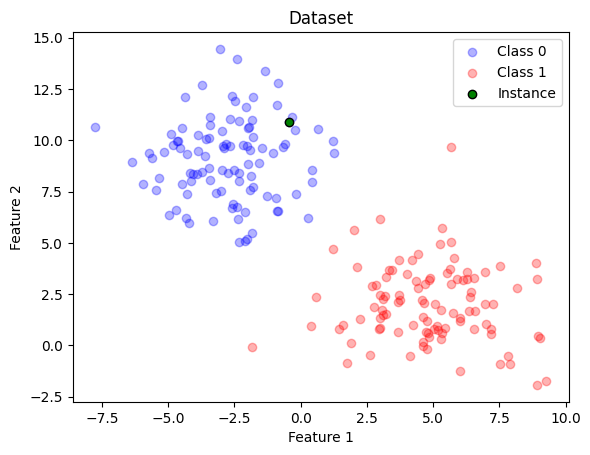

In [50]:
instance_to_explain = np.where(X==X_test[0])[0][0]

assert (X[instance_to_explain]==X_test[0]).all()

def plot_dataset_with_instance(X, y, highlight_row=None, counterfactual_instance=None, title="Dataset"):
    # Assuming you have two classes 0 and 1
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    # Create a scatter plot for each class
    plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0', alpha=0.3)
    plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class 1', alpha=0.3)
    
    if highlight_row is not None:
        plt.scatter(X[highlight_row, 0], X[highlight_row, 1], c='green', label='Instance', alpha=1, marker='o', edgecolors='k')
    
    if counterfactual_instance is not None:
        plt.scatter(counterfactual_instance[0], counterfactual_instance[1], c='cyan', label='Counterfactual Instance', alpha=1, marker='o', edgecolors='k')
        
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    
    # Add a legend to the plot
    plt.legend()
    
    plt.show()

# Pass in the index of the row you want to highlight
plot_dataset_with_instance(X, y, highlight_row=instance_to_explain)

Therefore, we want to find the _set of candidates_ that makes the **green** instance becomes **red**. For that, then let's use the `learn_counterfactuals` defined earlier with the following consierations:
- $x=$ the same instance that we are trying to get the counterfactuals, transformed from **std_features**
- $\text{yloss}$ is the hinge_loss that we defined earlier
- $\text{distance\_function}$ is the $\text{distance\_continuous}$ that was defined earlier
- $\text{lambda\_1}=\lambda_1=0.5$
- $\text{lambda\_2}=\lambda_2=1.0$
- $\text{model\_predict}$ will be our `net` model which we just trained
- $k=1$, so we are trying to learn a single counterfactual

In [51]:
x = torch.from_numpy(std_features.transform(X_test[0].reshape(1,-1)).astype(np.float32))
lambda_1 = torch.tensor(0.5)
lambda_2 = torch.tensor(1.0)
k = 1
learnt_counterfactuals = learn_counterfactuals(
    instance_to_analyze=x,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    yloss=hinge_yloss,
    distance_function=dist_continuous,
    model_classifier=net,
    k=k,
    training_dataset=torch.FloatTensor(X_train),
    num_epochs=100, 
    learning_rate=0.05
)

Number of epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Current loss: 14.245917320251465
Current loss: 10.61266040802002
Current loss: 6.298224449157715
Current loss: 0.13057315349578857
Current loss: 0.0851522833108902
Current loss: 0.08238514512777328
Current loss: 0.07698029279708862
Current loss: 0.07029037922620773
Current loss: 0.06286171078681946
Current loss: 0.05491942912340164


In [52]:
learnt_counterfactuals

[tensor([[-0.2011,  1.5717]], requires_grad=True)]

## Performing Adjustment

Perfect! We have learnt something :)

Let's see if it works after applying the post hoc adjustment

In [53]:
import torch

def post_hoc_adjustment(c_list, x, model, X_train, std_features):
    """
    Post-hoc filtering to promote sparsity in the counterfactuals.

    Parameters:
    c_list (List[torch.Tensor]): A list of counterfactual examples.
    x (torch.Tensor): The original input instance.
    model: The machine learning model that we are trying to explain.
    X_train (torch.Tensor): The training dataset.

    Returns:
    List[torch.Tensor]: The list of sparse counterfactuals.
    """

    # Calculate MAD values for each feature
    mad_values = median_abs_deviation(X_train)

    # Calculate the 10th percentile of absolute differences from the median
    p10_values = torch.kthvalue(torch.abs(X_train - torch.median(X_train, dim=0)[0]), int(0.1 * X_train.shape[0]), dim=0)[0]

    # Choose the lower value between the MAD and the 10th percentile for each feature
    thresholds = torch.minimum(mad_values, p10_values)

    # Prepare a container for sparse counterfactuals
    c_sparse_list = []

    # Apply the process to each instance in c_list
    for c in c_list:
        # Calculate the absolute differences between the counterfactual and the original instance
        original_scale_c = std_features.inverse_transform(c.detach().numpy().reshape(1,-1)).astype(np.float32)
        original_scale_x = std_features.inverse_transform(x.detach().numpy().reshape(1,-1)).astype(np.float32)
        abs_diff = torch.abs(torch.from_numpy(original_scale_c) - torch.from_numpy(original_scale_x))

        # Create a list of indices ordered by the absolute differences
        ordered_indices = torch.argsort(abs_diff)

        # Copy the counterfactual to avoid modifying the original
        c_sparse = c.clone()

        # Revert each feature until the predicted class changes
        for i in ordered_indices[0]:
            if abs_diff[0][i] < thresholds[i]:
                c_sparse[i] = x[0][i]
                if torch.argmax(model(c_sparse.unsqueeze(0))) != torch.argmax(model(c.unsqueeze(0))):
                    break

        c_sparse_list.append(c_sparse)

    return c_sparse_list

In [89]:
# Perform post-hoc filtering
c_sparse = post_hoc_adjustment(
    learnt_counterfactuals,
      torch.tensor(std_features.transform(x).astype(np.float32)), 
      net, 
      torch.FloatTensor(X_train), 
      std_features
)

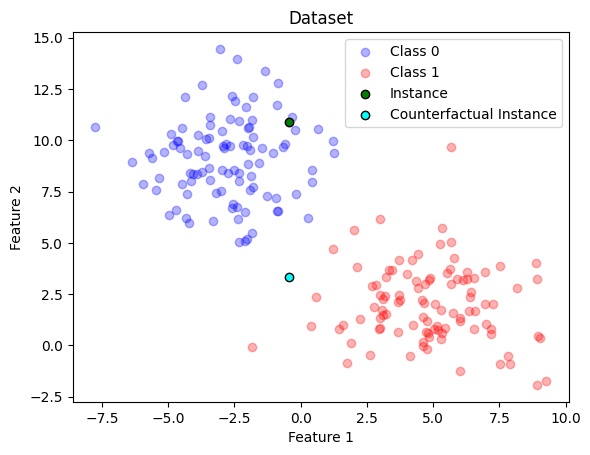

In [90]:
counterfactual_instance = std_features.inverse_transform(c_sparse[0].detach().numpy())[0]
plot_dataset_with_instance(X, y, highlight_row=instance_to_explain, counterfactual_instance=counterfactual_instance)

In [95]:
np.allclose(counterfactual_instance[0],x[0][0].numpy())

True

In [96]:
np.allclose(counterfactual_instance[1],x[0][1].numpy())

False

In [66]:
net.predict(torch.tensor(std_features.transform(counterfactual_instance.reshape(1,-1))).unsqueeze(0))

tensor([[[1.]]])

In [72]:
net.predict(x)

tensor([[0.]])

# Conclusion